# 젠더 법안 K-means

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
from gensim import models
import fasttext.util
from sklearn.cluster import AgglomerativeClustering
from konlpy.tag import Okt
import logging
from krwordrank.hangle import normalize
%matplotlib inline

In [2]:
# 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


In [3]:
gender = pd.read_csv('./15th-gender-bill.csv', 
                      index_col=0, parse_dates=['제안일자','의결일자'] )
# gender = gender.drop('level_0',1)
print(gender.shape)

(83, 10)


In [4]:
gender.head()

,의안번호,의안명,제안일자,제안자구분,의결일자,의결결과,제안회기,제안이유,소관위원회,제안자
0,152550,청소년의성보호에관한법률안,2000-01-13,위원장,2000-01-14,원안가결,제15대 (1996~2000) 제209회,1. 1999년 11월 4일 박상천·林채정·정세균·방용석의원외 101인이 발의...,정무위원회,[]
1,152499,사립학교법중개정법률안,1999-12-17,위원장,1999-12-28,원안가결,제15대 (1996~2000) 제209회,1. 1999년 9월 10일 李미경의원외 23인이 발의하여 동일 우리 위원회에...,교육위원회,[]
2,152498,교육공무원법중개정법률안,1999-12-17,위원장,1999-12-28,원안가결,제15대 (1996~2000) 제209회,1. 1999년 8월 16일 李미경의원외 23인이 발의하여 동년 9월 10일 ...,교육위원회,[]
3,152488,남녀고용평등법중개정법률안,1999-12-16,의원,2000-05-29,임기만료폐기,제15대 (1996~2000) 제208회,현재 무급인 육아휴직기간의 소득보장을 위하여 고용보험법에서 임金의 일부를 지급...,환경노동위원회,"['김정숙', '권영자', '김영선', '김영환', '김칠환', '박근혜', '박범..."
4,152486,국민건강보험법중개정법률안,1999-12-16,의원,2000-05-29,임기만료폐기,제15대 (1996~2000) 제208회,여성의 모성기능 보호의 일환으로 임산부가 태아건강검진을 받고 산전후 휴식을 취...,보건복지위원회,"['김정숙', '권영자', '김영선', '김영환', '김칠환', '박근혜', '박범..."


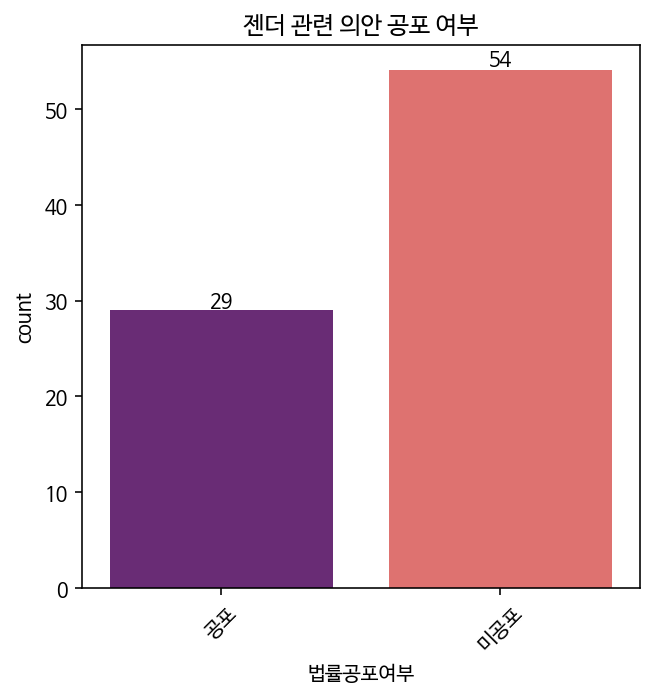

In [5]:
def proornot_vis(df, name): 
    plt.figure(figsize = (5,5))
    plt.xticks(rotation = 45)
    ax = sns.countplot(x = '법률공포여부', data = df, 
              palette = 'magma')

    for p in ax.patches: 
        left, bottom, width, height = p.get_bbox().bounds 
        ax.annotate("%.1d"%(height), (left+width/2, height*1.01), ha='center')

    plt.title(f'{name} 관련 의안 공포 여부')
    plt.show()

proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

gender.loc[gender['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
gender.loc[gender['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

proornot_vis(gender, '젠더')

In [4]:
# 한글 전처리
def preprocessing(text): 
    text_pre1 = re.sub('[-=.#/:$}·,■?]', ' ', text)
    text_pre2 = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text_pre1)
    return str(text_pre2)

# 의미없는 단어 삭제 
def remove_stopword(text): 
    stopwords = ['사이','을','이','의','를','에','가','들','은','는','으로','한','도','항','관','정',
              '수','에서','로','것','그','과','제','입니다','할','하고','적','하는','로부터','면','관','항','이',
              '합니다','와','에게','고','인','하여','등','저','있습니다','말','까지','일명',
              '그리고','다','만','했습니다','안','된','못','일','더','위','최근','인한','있어'
              '있는','해','또한','명','하지','정말','물','많은','것임','류','줄','통해',
              '중','게','너무','자','이런','때','되지','위해','에는','없는','중','물이',
              '및','요','때문','관련','대한','전','라고','되었습니다','하기','나','후','같은','해서',
              '글','되어','주','차','하','내','없이','대해','잘','항','조','경우','함안','기간','하려는','일부',
              '마련','있도록','또는','함','하도록','개월','분','부터','제호','관','되고','년','월','및','등',\
              '안','바','이','것','부터','수','시','자']

    text = [word for word in text if word not in stopwords]
    return text

In [5]:
gender['의안텍스트'] = (gender['의안명'] + ' ' + gender['제안이유']).str.strip()
gender['의안텍스트'] = gender['의안텍스트'].apply(lambda x:str(x).lower())

In [6]:
%time gender['의안텍스트'] = gender['의안텍스트'].apply(preprocessing)

CPU times: user 13.5 ms, sys: 807 µs, total: 14.3 ms
Wall time: 16.1 ms


In [7]:
from konlpy.tag import Mecab, Okt, Hannanum

# okt = Okt()
hannanum = Hannanum()

def get_tokens(x):
    try:
        return [i for i in hannanum.nouns(x) if len(i) > 1] if x else []
    except Exception as e:
        if str(x) == 'nan':
            return []
        print(e)
        print(str(x))
        raise e

In [8]:
# 단어에서 명사만 뽑아내기
# okt = Okt()
%time gender['tokens'] = gender['의안텍스트'].apply(get_tokens)
gender['tokens'][:3]

CPU times: user 21.8 s, sys: 492 ms, total: 22.3 s
Wall time: 12.2 s


0    [청소년의성보호에관한법률안, 박상천, 채정, 정세균, 방용석의원, 발의, 아동, 청...
1    [사립학교법중개정법률, 미경의원외, 발의, 우리, 위원회, 회부, 사립학교법중개정법...
2    [교육공무원법중개정법률, 미경의원외, 발의, 동년, 우리, 위원회, 회부, 교육공무...
Name: tokens, dtype: object

In [9]:
%time gender['tokens'] = gender['tokens'].apply(remove_stopword)

CPU times: user 30.7 ms, sys: 1.44 ms, total: 32.2 ms
Wall time: 35.1 ms


In [10]:
%time gender['명사수'] = gender['tokens'].apply(len)

CPU times: user 1.12 ms, sys: 130 µs, total: 1.25 ms
Wall time: 1.25 ms


In [11]:
# 명사 수가 50개를 넘어가는 경우만 추출
gender = gender[gender['명사수'] >= 10]
gender = gender.reset_index(drop=True)
print(gender.shape)

(83, 13)


In [12]:
# word2vec 모델 학습에 로그를 찍기
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', 
    level=logging.INFO)

In [13]:
# 모델 생성

#포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 주변 단어(window)는 앞뒤로 두개까지 보고, 코퍼스 내 출현 빈도가 10번 미만인 단어는 분석에서 제외해라.
#CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
model = Word2Vec(gender['tokens'], size=100, window = 10, min_count=10, workers=4, iter=100, sg=0)

2020-09-27 00:03:01,588 : INFO : collecting all words and their counts
2020-09-27 00:03:01,593 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-27 00:03:01,603 : INFO : collected 3545 word types from a corpus of 11984 raw words and 83 sentences
2020-09-27 00:03:01,604 : INFO : Loading a fresh vocabulary
2020-09-27 00:03:01,608 : INFO : effective_min_count=10 retains 232 unique words (6% of original 3545, drops 3313)
2020-09-27 00:03:01,610 : INFO : effective_min_count=10 leaves 5103 word corpus (42% of original 11984, drops 6881)
2020-09-27 00:03:01,617 : INFO : deleting the raw counts dictionary of 3545 items
2020-09-27 00:03:01,623 : INFO : sample=0.001 downsamples 139 most-common words
2020-09-27 00:03:01,624 : INFO : downsampling leaves estimated 3362 word corpus (65.9% of prior 5103)
2020-09-27 00:03:01,626 : INFO : estimated required memory for 232 words and 100 dimensions: 301600 bytes
2020-09-27 00:03:01,627 : INFO : resetting layer weights
202

2020-09-27 00:03:01,957 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:01,958 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:01,960 : INFO : EPOCH - 15 : training on 11984 raw words (3356 effective words) took 0.0s, 337082 effective words/s
2020-09-27 00:03:01,971 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:01,972 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:01,973 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:01,974 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:01,975 : INFO : EPOCH - 16 : training on 11984 raw words (3389 effective words) took 0.0s, 378371 effective words/s
2020-09-27 00:03:01,988 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:01,990 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

2020-09-27 00:03:02,198 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,201 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,203 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,205 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,206 : INFO : EPOCH - 32 : training on 11984 raw words (3376 effective words) took 0.0s, 444507 effective words/s
2020-09-27 00:03:02,212 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,216 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,218 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,219 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,221 : INFO : EPOCH - 33 : training on 11984 raw words (3422 effective words) took 0.0s, 313883 effective words/s
2020-0

2020-09-27 00:03:02,437 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,437 : INFO : EPOCH - 48 : training on 11984 raw words (3383 effective words) took 0.0s, 527570 effective words/s
2020-09-27 00:03:02,442 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,445 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,447 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,448 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,450 : INFO : EPOCH - 49 : training on 11984 raw words (3354 effective words) took 0.0s, 391278 effective words/s
2020-09-27 00:03:02,456 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,459 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,460 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-0

2020-09-27 00:03:02,661 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,663 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,664 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,665 : INFO : EPOCH - 65 : training on 11984 raw words (3379 effective words) took 0.0s, 345018 effective words/s
2020-09-27 00:03:02,671 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,673 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,675 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,676 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,677 : INFO : EPOCH - 66 : training on 11984 raw words (3408 effective words) took 0.0s, 545053 effective words/s
2020-09-27 00:03:02,684 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-0

2020-09-27 00:03:02,913 : INFO : EPOCH - 81 : training on 11984 raw words (3381 effective words) took 0.0s, 225438 effective words/s
2020-09-27 00:03:02,927 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,931 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,932 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,933 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:02,937 : INFO : EPOCH - 82 : training on 11984 raw words (3386 effective words) took 0.0s, 353191 effective words/s
2020-09-27 00:03:02,943 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:02,947 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:02,951 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:02,954 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-0

2020-09-27 00:03:03,262 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:03,263 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:03,265 : INFO : EPOCH - 98 : training on 11984 raw words (3308 effective words) took 0.0s, 337221 effective words/s
2020-09-27 00:03:03,271 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:03,272 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-09-27 00:03:03,275 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-09-27 00:03:03,276 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-09-27 00:03:03,278 : INFO : EPOCH - 99 : training on 11984 raw words (3401 effective words) took 0.0s, 350854 effective words/s
2020-09-27 00:03:03,284 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-09-27 00:03:03,286 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-0

In [14]:
# 문장 벡터 생성
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(model.wv[i])
        except:
            pass
    try:
        return np.mean(vector, axis=0)
    except:
        pass
    
# 엘보우 함수
def elbow(X):
    sse = []
    for i in tqdm(range(1,15), desc = '엘보우'):
        km = KMeans(init='k-means++', n_clusters = i, random_state=0)
        km.fit(X)
        sse.append(km.inertia_)
        
    plt.plot(range(1,15), sse, marker='o')
    plt.xlabel("number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [15]:
# 문장 벡터 생성
gender['문장벡터'] = gender['tokens'].map(get_sentence_mean_vector)

In [16]:
len(gender['문장벡터'][0])

100

In [17]:
print(model.wv.most_similar('여성'))
print(model.wv.most_similar('청소년'))

2020-09-27 00:03:03,391 : INFO : precomputing L2-norms of word weight vectors


[('도모', 0.8959028720855713), ('촉진', 0.7523329257965088), ('중소기업청장', 0.726104199886322), ('적극적', 0.6923993825912476), ('여성기업', 0.6201220750808716), ('활동', 0.6156735420227051), ('개선', 0.590459406375885), ('추진', 0.5785374045372009), ('실질적', 0.5766624212265015), ('수립', 0.5727501511573792)]
[('알선', 0.8394574522972107), ('행위', 0.8213979005813599), ('제작', 0.7971785068511963), ('용음란물', 0.7276672720909119), ('성장', 0.7263956069946289), ('강요', 0.7243825197219849), ('아동', 0.711466908454895), ('이용', 0.6749739646911621), ('대상', 0.6701861023902893), ('판매', 0.6469942331314087)]


In [19]:
# model.wv.vocab.items()

## t-SNE 시각화

In [18]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

wv_list = list(gender['문장벡터'])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(wv_list)

tsne_df = pd.DataFrame(tsne_results, index=gender['의안명'], columns=["x", "y"])

[t-SNE] Computing 82 nearest neighbors...
[t-SNE] Indexed 83 samples in 0.000s...
[t-SNE] Computed neighbors for 83 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 83 / 83
[t-SNE] Mean sigma: 2.600835
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.753742
[t-SNE] KL divergence after 300 iterations: 0.856378


In [19]:
tsne_df.head()

,x,y
의안명,,
청소년의성보호에관한법률안,10.709967,-3.965045
사립학교법중개정법률안,13.733586,2.573734
교육공무원법중개정법률안,-2.230072,15.503713
남녀고용평등법중개정법률안,13.902528,11.985868
국민건강보험법중개정법률안,-7.057769,-3.628804


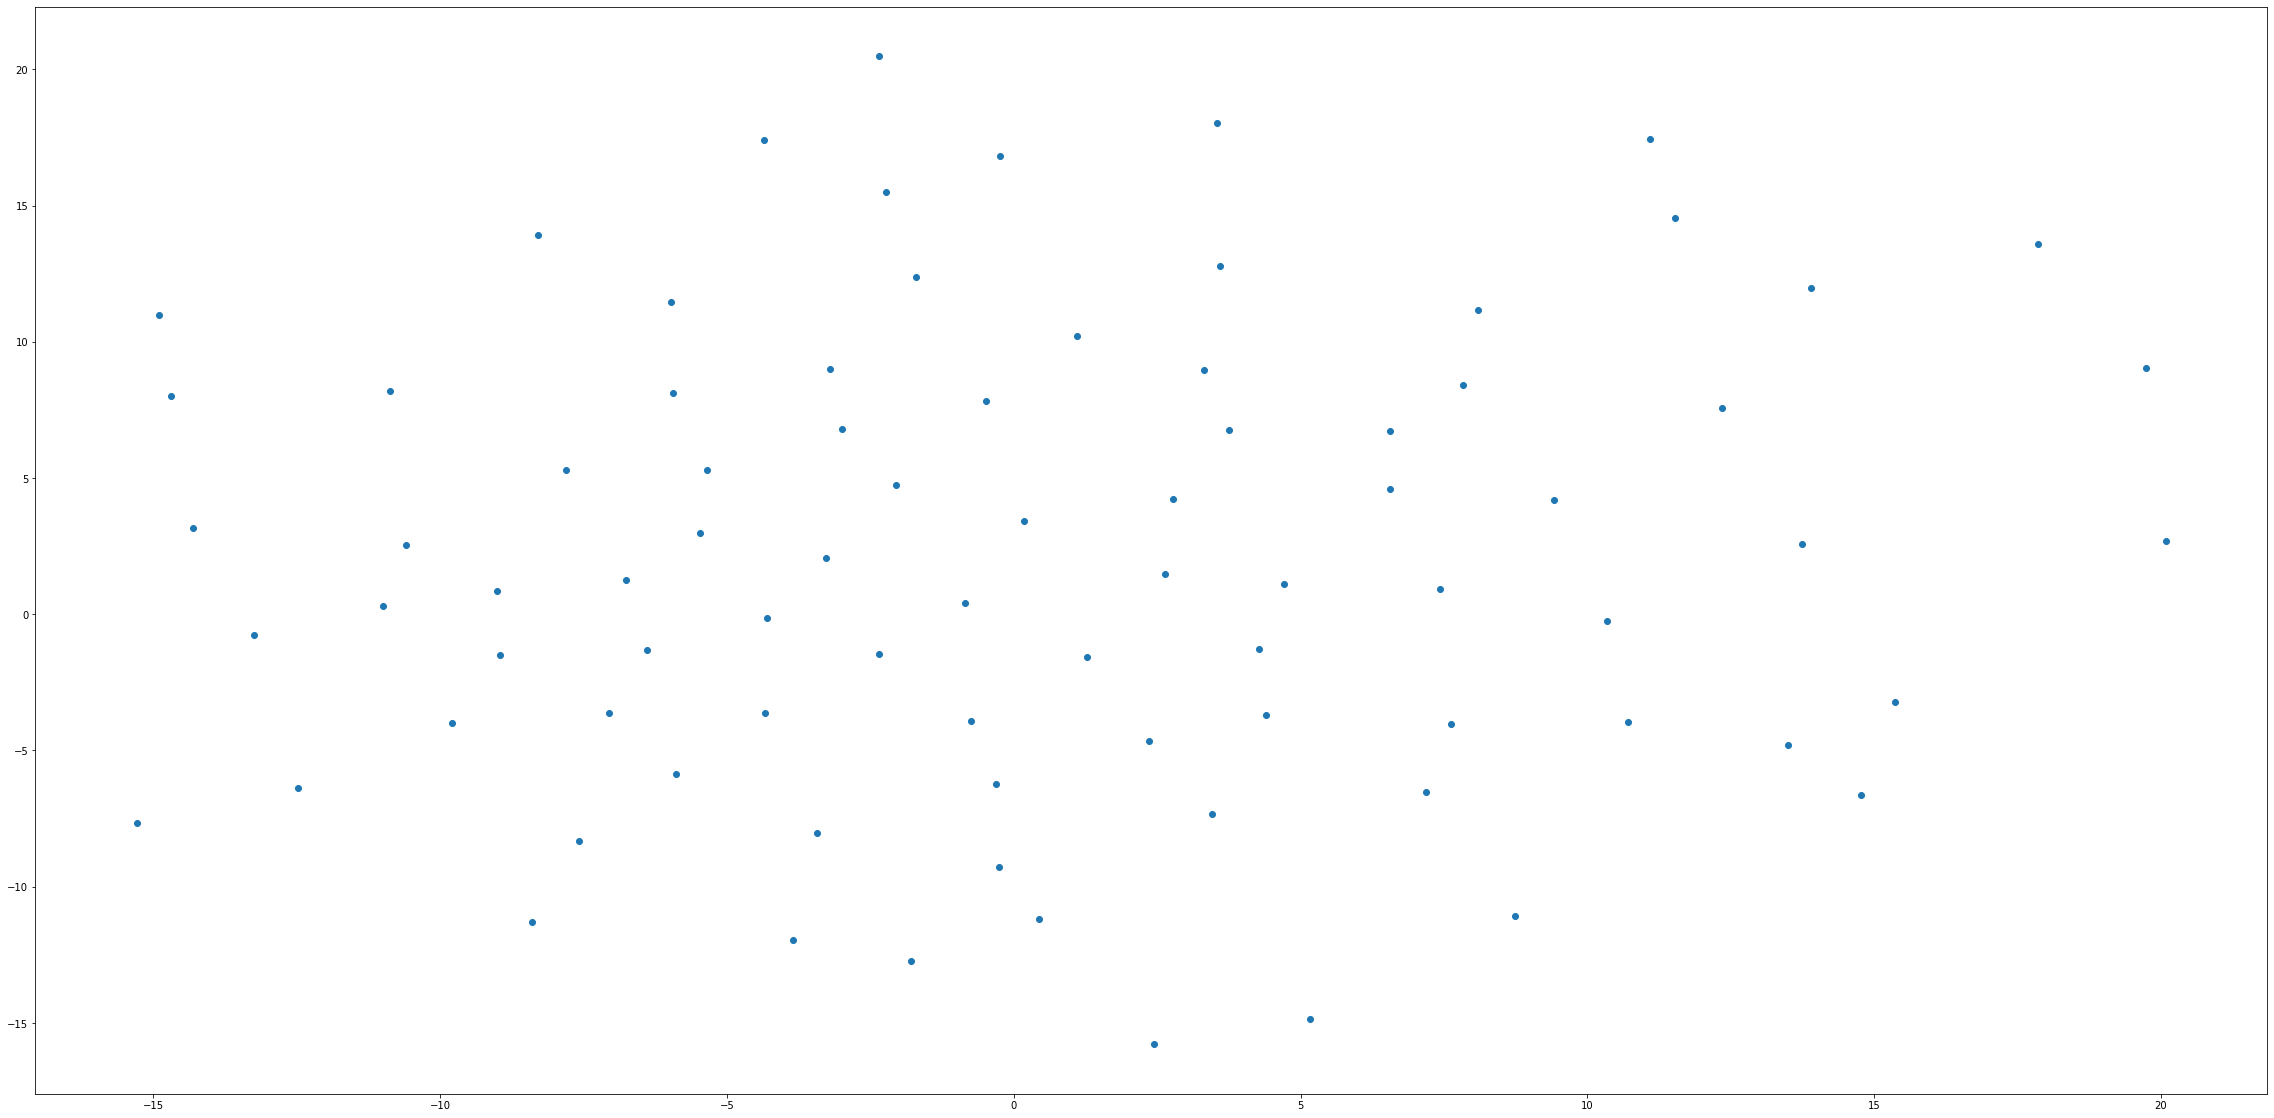

In [20]:
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(40, 20)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_df["x"], tsne_df["y"])

#for word, pos in list(df.iterrows()):
#    ax.annotate(word, pos, fontsize=12, fontproperties=prop)
plt.show()

## 군집개수 결정 - 엘보우 함수

엘보우: 100%|██████████| 14/14 [00:00<00:00, 18.44it/s]


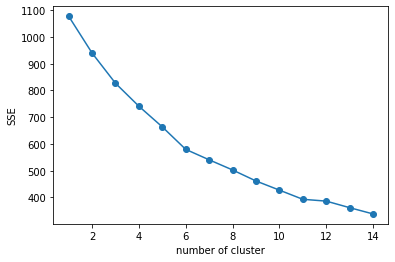

In [21]:
# 엘보우 함수로 군집 개수 결정

word_vectors = gender['문장벡터'].to_list() # 함수에 넣을 X값 지정
elbow(word_vectors)

## 군집개수 결정 - 실루엣 계수

In [22]:
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from matplotlib import cm

def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric = 'euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)

    silhoutte_avg = np.mean(silhouette_vals)
    plt.axvline(silhoutte_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel('K')
    plt.xlabel('silhouette')
    plt.show()

## KMeans

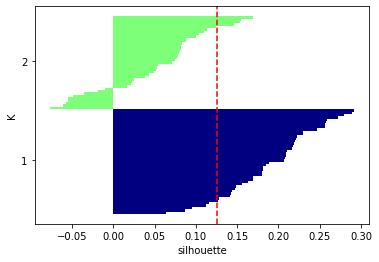

In [23]:
word_vectors = gender['문장벡터'].to_list()
k= 2

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

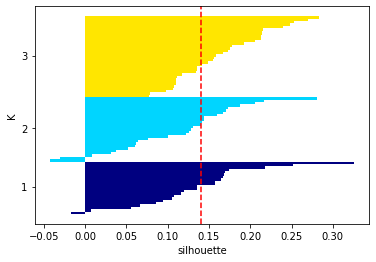

In [24]:
word_vectors = gender['문장벡터'].to_list()
k= 3

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

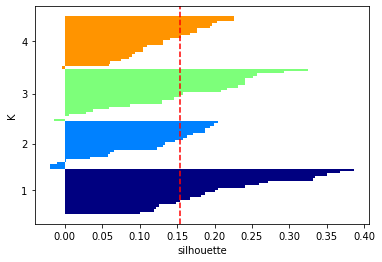

In [25]:
word_vectors = gender['문장벡터'].to_list()
k= 4

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

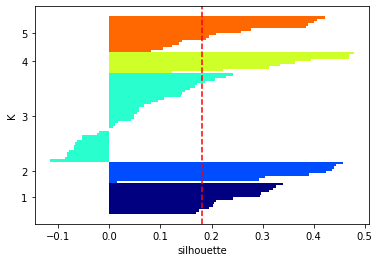

In [26]:
word_vectors = gender['문장벡터'].to_list()
k= 5

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

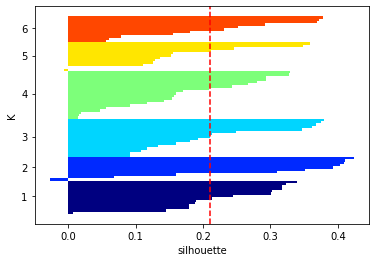

In [27]:
word_vectors = gender['문장벡터'].to_list()
k= 6

X, y = make_blobs(n_samples=150, n_features=2, centers=3, cluster_std=0.5,
                  shuffle=True, random_state=0)
km = KMeans(n_clusters=k, algorithm='auto', random_state=42)
y_km = km.fit_predict(word_vectors)
plotSilhouette(word_vectors, y_km)

## KMeans 수행

In [28]:
# K means 수행 
word_vectors = gender['문장벡터'].to_list()
num_clusters = 4

kmeans_clustering = KMeans(n_clusters = num_clusters)
idx = kmeans_clustering.fit_predict(word_vectors)
gender['category'] = idx

In [29]:
gender['category'].value_counts()

1    27
3    24
0    22
2    10
Name: category, dtype: int64

In [30]:
from sklearn.manifold import TSNE

X = gender['문장벡터'].to_list()
y = gender['category'].to_list()

import os.path
import pickle

tsne_filepath = 'tsne3000.pkl'

tsne = TSNE(random_state=42)
tsne_points = tsne.fit_transform(X)

'''
# File Cache
if not os.path.exists(tsne_filepath):
    tsne = TSNE(random_state=42)
    tsne_points = tsne.fit_transform(X)
    with open(tsne_filepath, 'wb+') as f:
        pickle.dump(tsne_points, f)
else: # Cache Hits!
    with open(tsne_filepath, 'rb') as f:
        tsne_points = pickle.load(f)
'''

tsne_df = pd.DataFrame(tsne_points, index=range(len(X)), columns=['x_coord', 'y_coord'])
tsne_df['BillNo'] = gender['의안번호'].to_list()
tsne_df['BillName'] = gender['의안명'].to_list()
tsne_df['cluster_no'] = y

In [31]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, value
from bokeh.palettes import brewer

output_notebook()

Loading BokehJS ...

In [32]:
# 색 정해주기

colors = brewer["Spectral"][len(tsne_df['cluster_no'].unique())]
colormap = {i: colors[i] for i in tsne_df['cluster_no'].unique()}
colors = [colormap[x] for x in tsne_df['cluster_no']]
tsne_df['color'] = colors

In [33]:
# Bokeh가 인식하는 DataSource 객체 만들어주기
plot_data = ColumnDataSource(
    data=tsne_df.to_dict(orient='list')
)

# Plot 만들기(배경)
tsne_plot = figure(
    title='Bills about gender',
    plot_width = 650,
    plot_height = 650,
    active_scroll='wheel_zoom',
    output_backend="webgl", # GPU 가속
)

In [34]:
# 마우스 올렸을 때 보여줄 것

tsne_plot.add_tools(
    HoverTool(
        tooltips= '@BillName'
    )
)

# 데이터 정보 넣기

tsne_plot.circle(
    source=plot_data,
    x='x_coord',
    y='y_coord',
    line_alpha=0.3, 
    fill_alpha=0.2,
    size=10,
    fill_color='color',
    line_color='color',
)

# 선 지우기

tsne_plot.title.text_font_size = value('16pt')
tsne_plot.xaxis.visible = False
tsne_plot.yaxis.visible = False
tsne_plot.grid.grid_line_color = None
tsne_plot.outline_line_color = None


show(tsne_plot)


## 군집별 핵심단어 추출

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Unable to locate an executable at "/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home/bin/apt" (-1)


2020-09-27 00:03:25,998 : INFO : Generating new fontManager, this may take some time...
2020-09-27 00:03:26,636 : INFO : Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
2020-09-27 00:03:26,905 : INFO : Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
2020-09-27 00:03:26,995 : INFO : Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)


In [36]:
gender_g1 = gender[gender['category'] == 0]
gender_g2 = gender[gender['category'] == 1]
gender_g3 = gender[gender['category'] == 2]
gender_g4 = gender[gender['category'] == 3]
gender_g5 = gender[gender['category'] == 4]
# gender_g6 = gender[gender['category'] == 5]
# gender_g7 = gender[gender['category'] == 6]

In [37]:
import nltk 
from wordcloud import WordCloud

def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰를 정렬하여 보여줌 
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = '/usr/share/fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
            
gender_g1_tokens = total_tokens(gender_g1['tokens'])
gender_g2_tokens = total_tokens(gender_g2['tokens'])
gender_g3_tokens = total_tokens(gender_g3['tokens'])
gender_g4_tokens = total_tokens(gender_g4['tokens'])
gender_g5_tokens = total_tokens(gender_g5['tokens'])
# gender_g6_tokens = total_tokens(gender_g6['tokens'])

In [49]:
stopwords = ['조치','법률','일부개정법률안','현행법','이하','규정하','해당','사실','실시','조제','조의','발생','필요','포함','실정','상황',
            '이용','사람','사건','사항','운영','이상','선고', '대안','대표발의','국회','문장','신설','위원회','국민','임시회','법률안','회부',
            '규정','항제','제안','발의','부의','우리']
gender_g1_tokens = [each_word for each_word in gender_g1_tokens if each_word not in stopwords]
gender_g2_tokens = [each_word for each_word in gender_g2_tokens if each_word not in stopwords]
gender_g3_tokens = [each_word for each_word in gender_g3_tokens if each_word not in stopwords]
gender_g4_tokens = [each_word for each_word in gender_g4_tokens if each_word not in stopwords]
gender_g5_tokens = [each_word for each_word in gender_g5_tokens if each_word not in stopwords]
# gender_g6_tokens = [each_word for each_word in gender_g6_tokens if each_word not in stopwords]

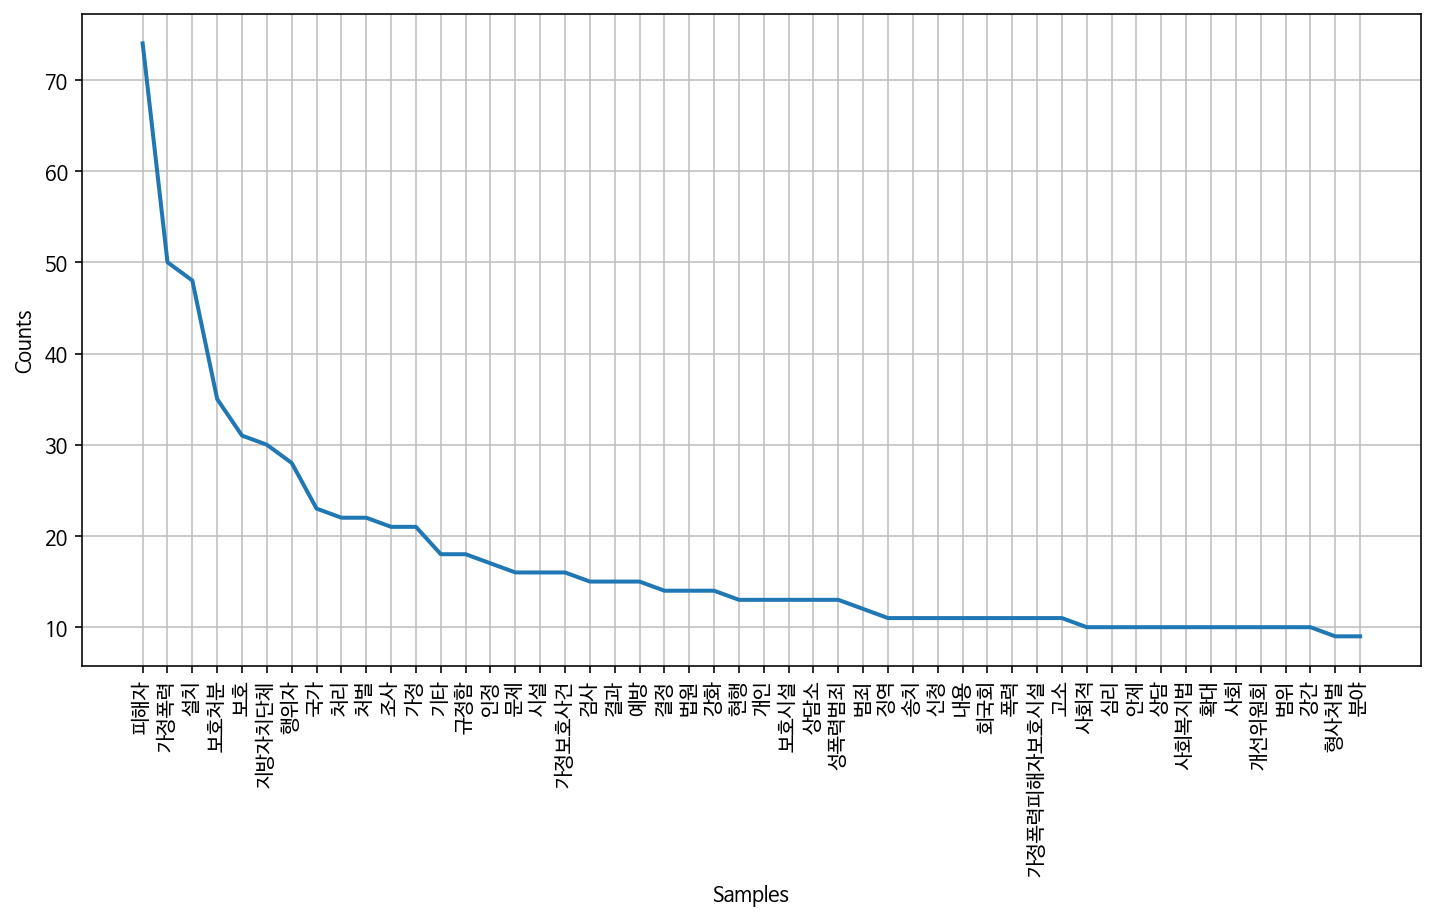

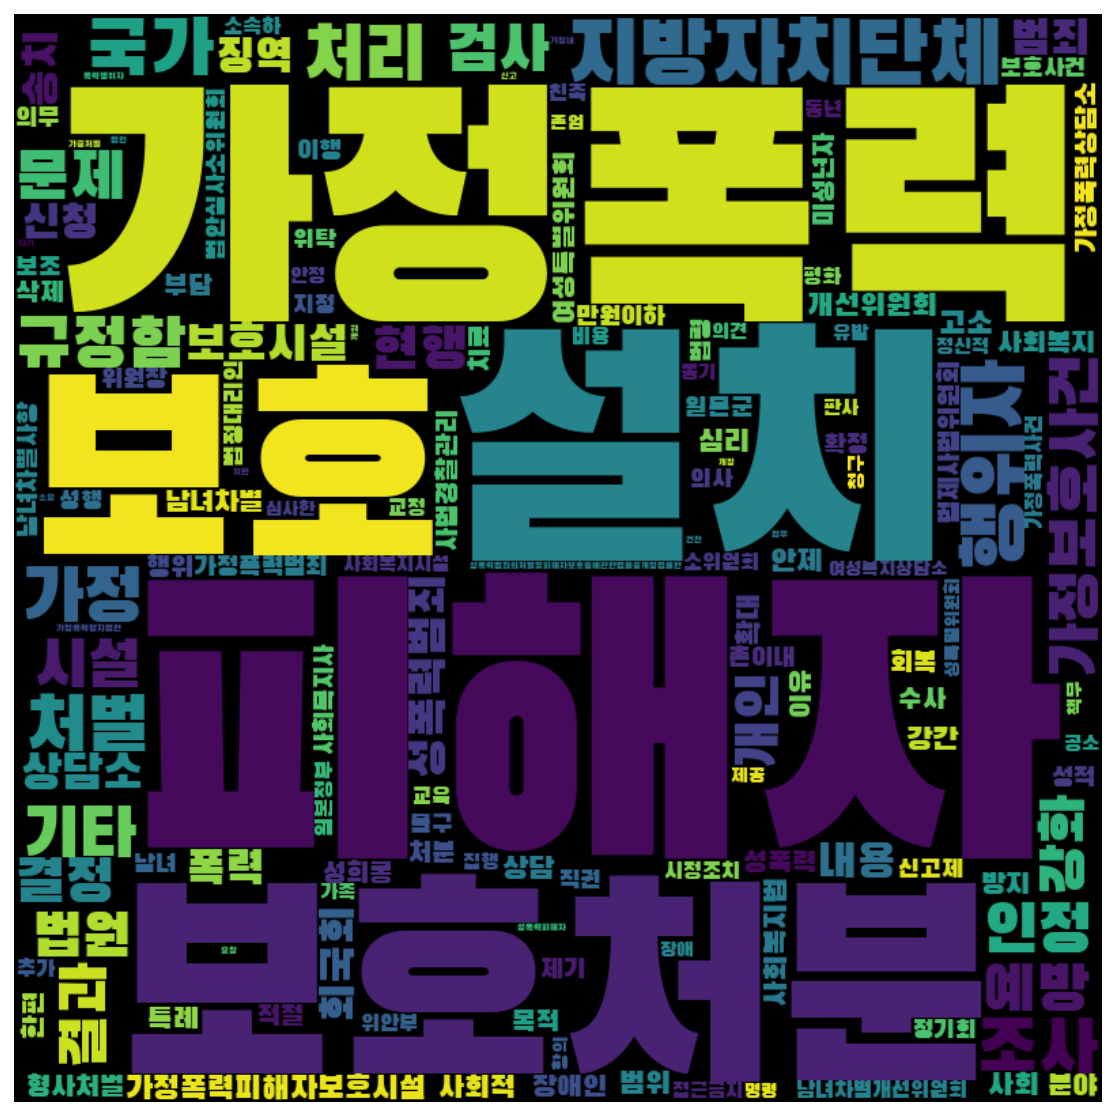

In [50]:
frewords_vis(gender_g1_tokens)
wordcloud_vis(gender_g1_tokens)

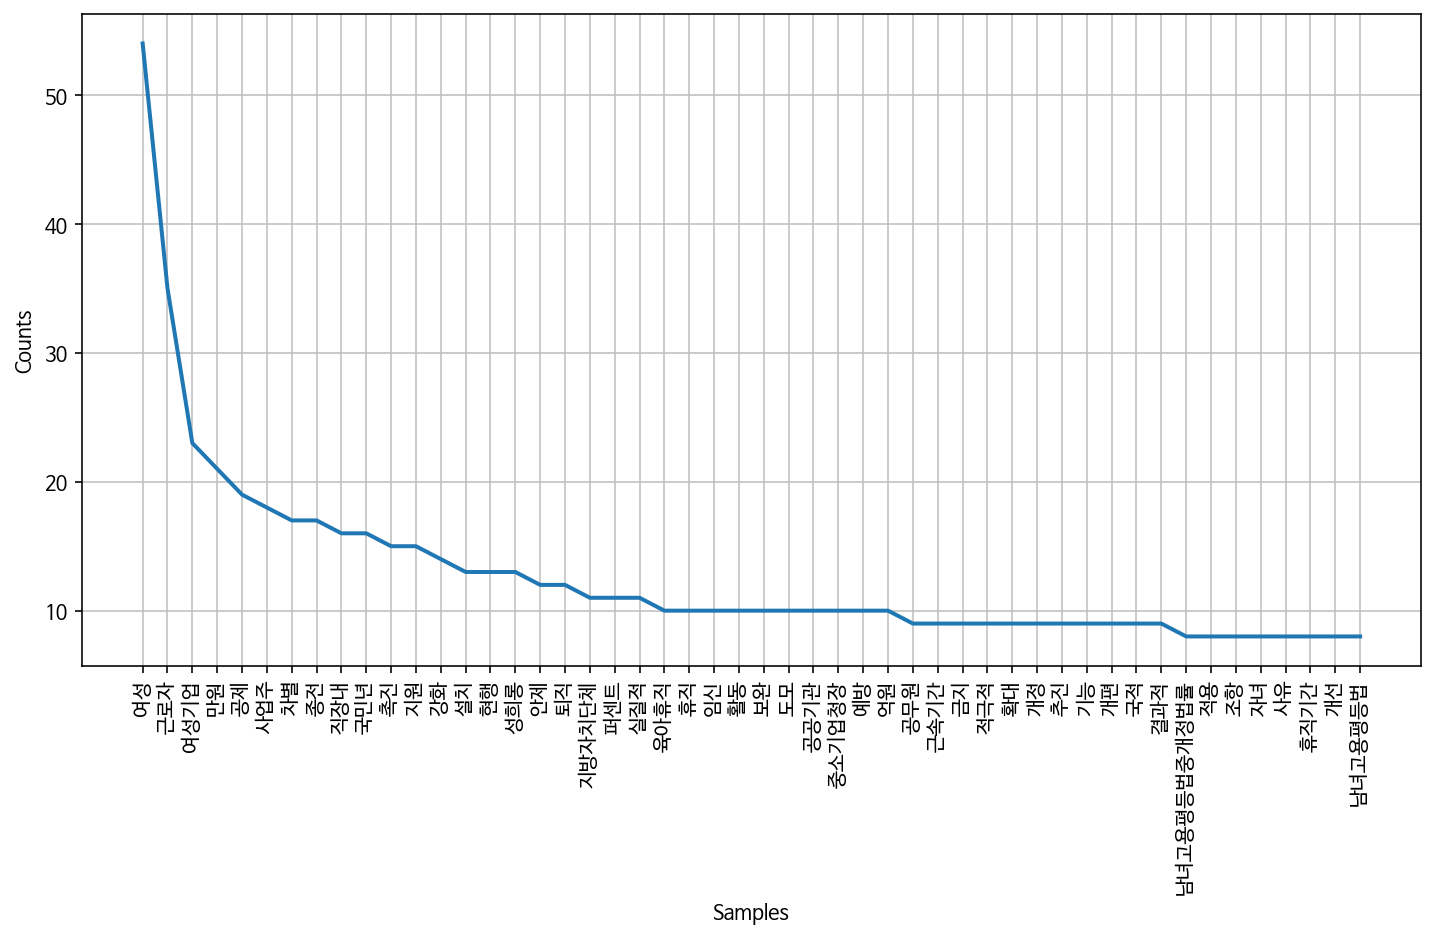

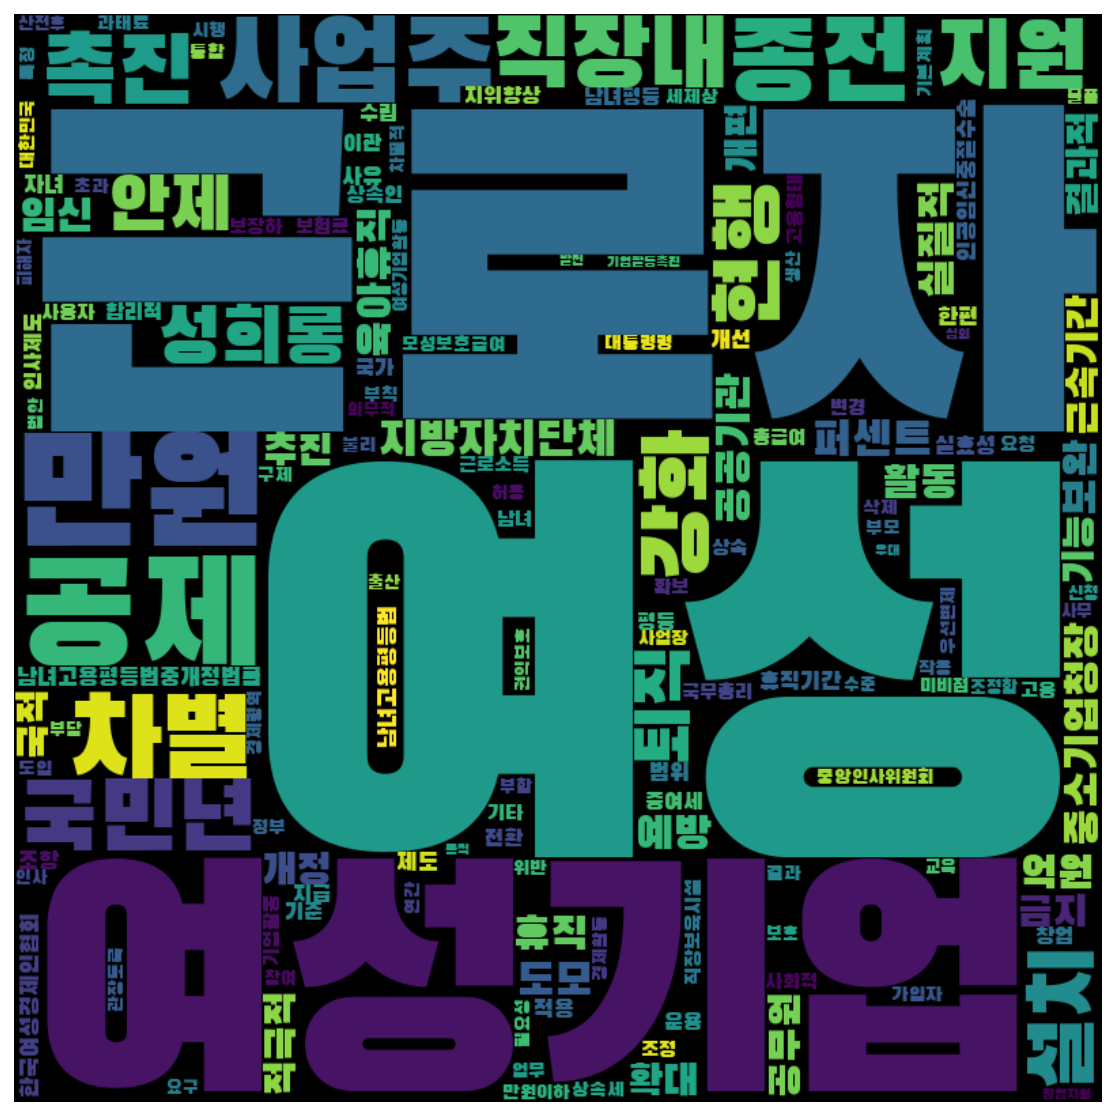

In [51]:
frewords_vis(gender_g2_tokens)
wordcloud_vis(gender_g2_tokens)

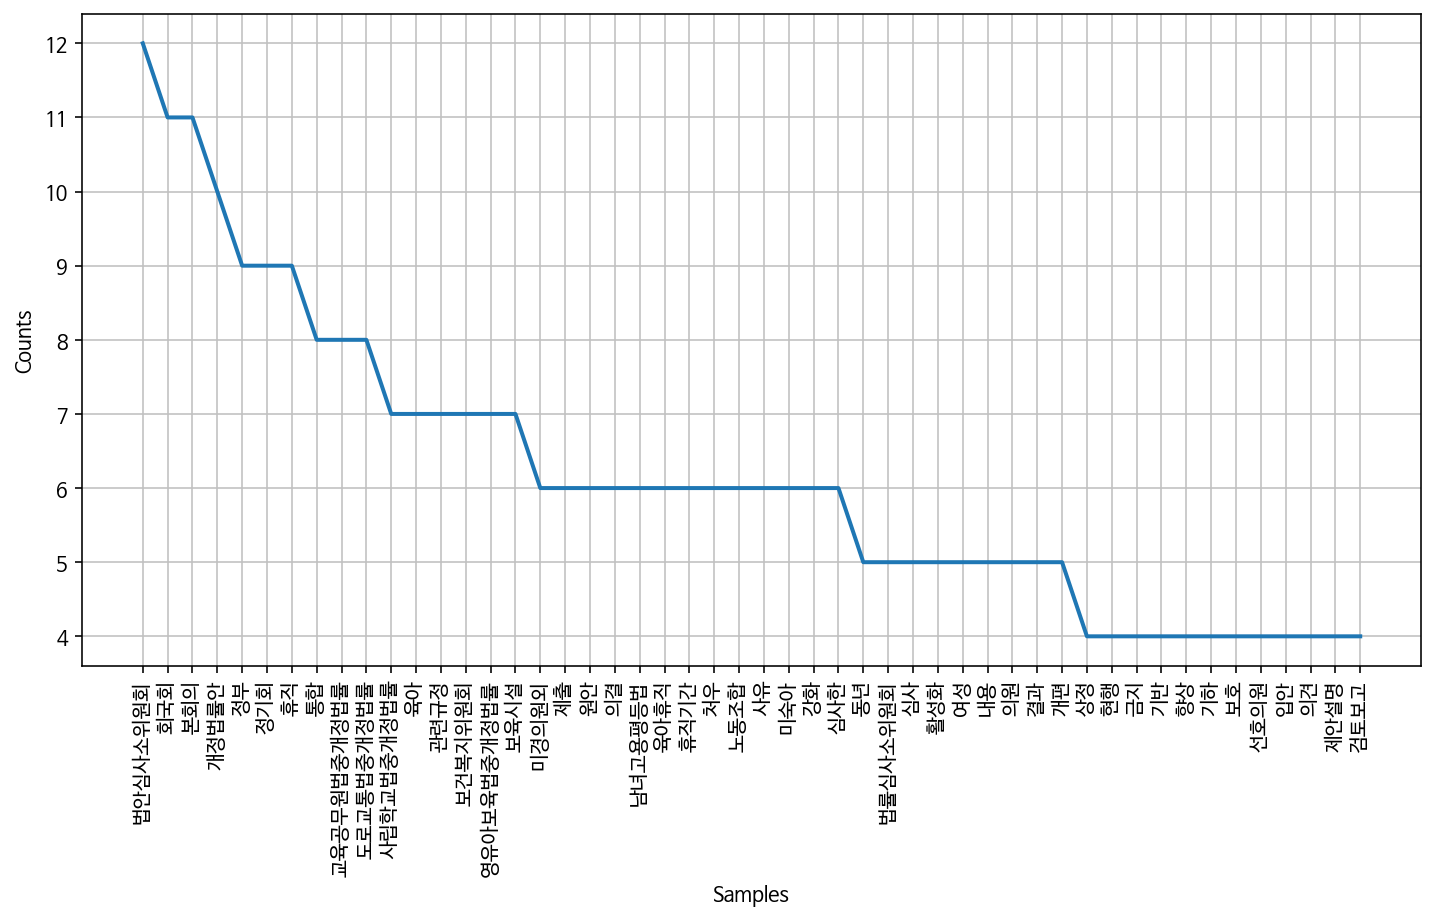

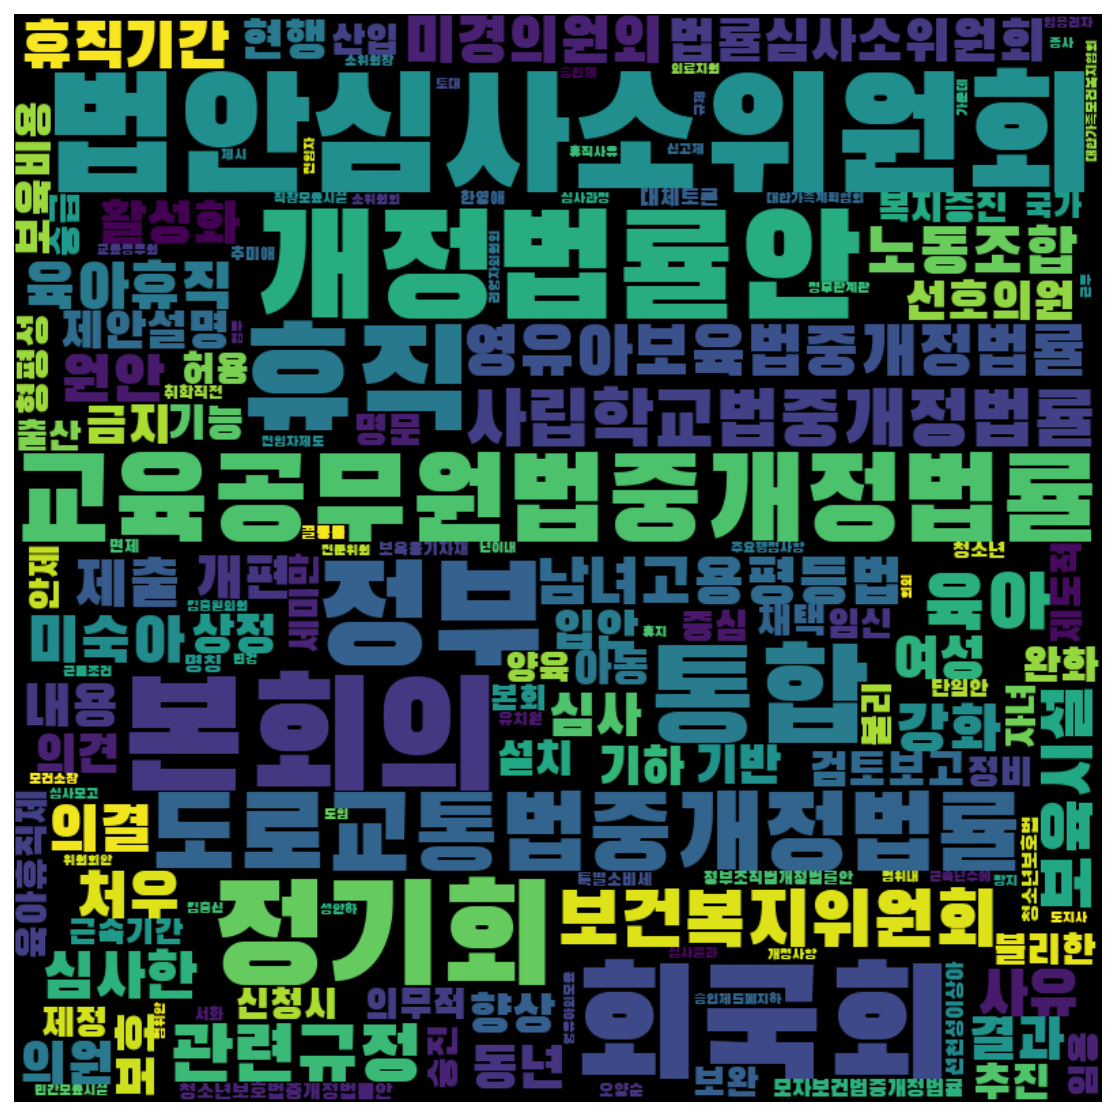

In [52]:
frewords_vis(gender_g3_tokens)
wordcloud_vis(gender_g3_tokens)

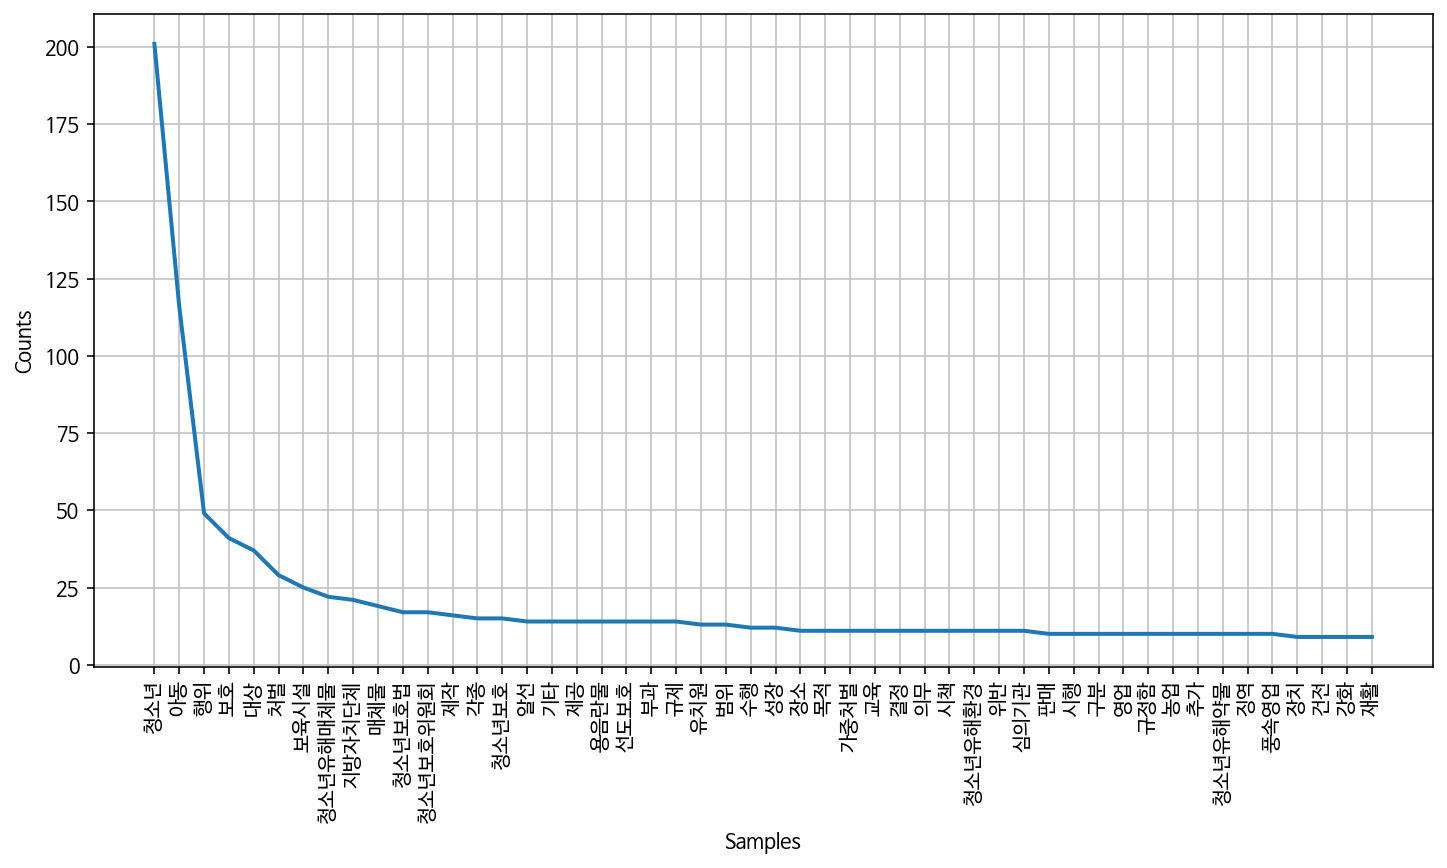

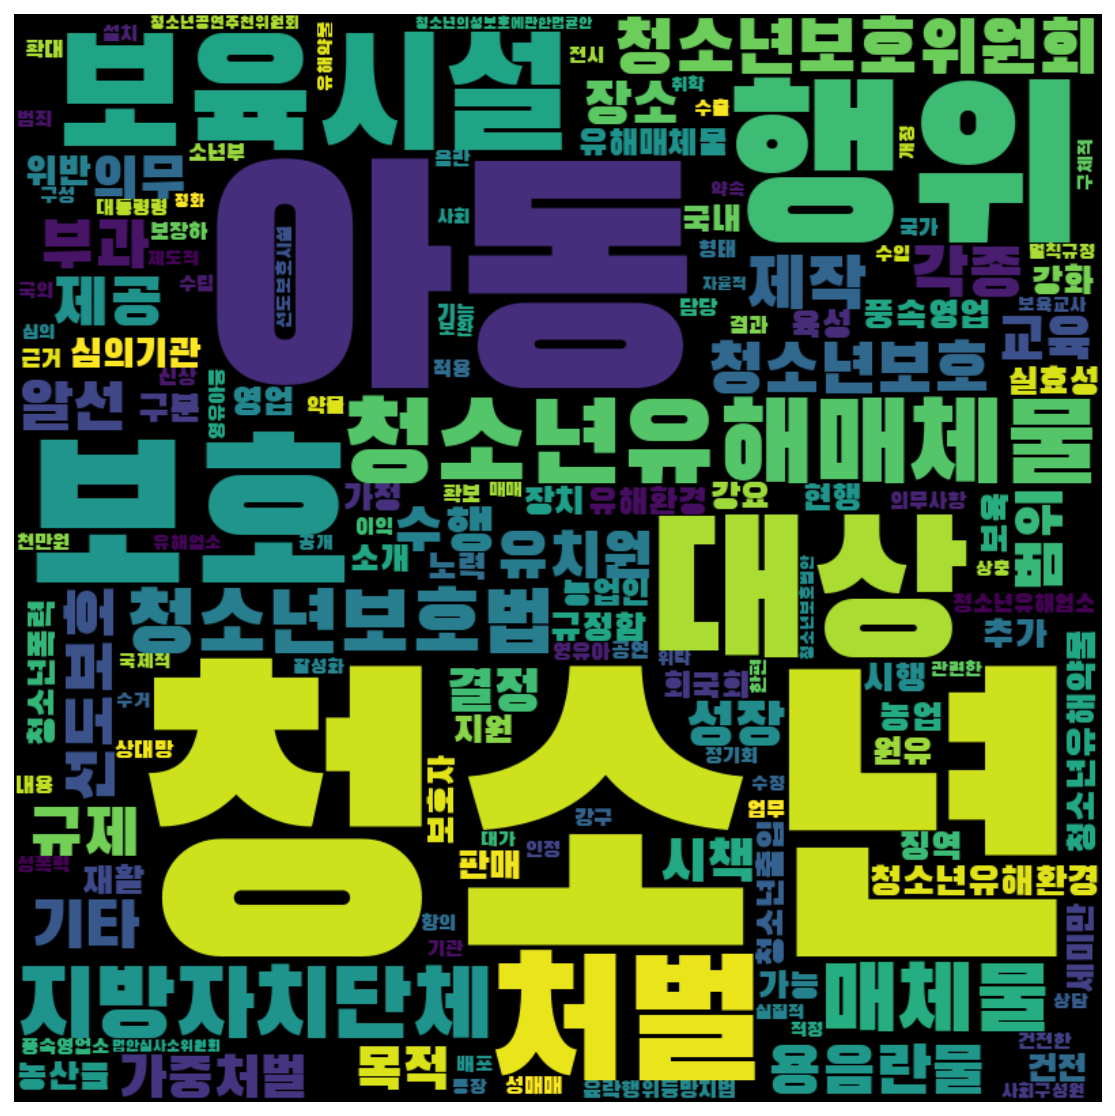

In [53]:
frewords_vis(gender_g4_tokens)
wordcloud_vis(gender_g4_tokens)

In [43]:
# frewords_vis(gender_g5_tokens)
# wordcloud_vis(gender_g5_tokens)

In [70]:
# frewords_vis(gender_g6_tokens)
# wordcloud_vis(gender_g6_tokens)